<img align="center" src="./images/occiput_logo3.png" width="400">

# PET reconstruction with motion information - examples
This notebook presents examples of reconstruction with motion information using a variety of techniques. 
The outline of the notebook is the following: 

- Simulate acquisition with motion
  - 1) Create activity phantom
  - 2) Simulate random motion
  - 3) Simulate PET acquisition
- Reconstruct
  - 1) Reconstruct frames independently with OSEM, unknown motion 
  - 2) Reconstruct frames independently with OSEM algorithm, known motion - version A: use PET_Static_Scan
  - 3) Reconstruct frames independently  with OSEM algorithm, known motion - version B: use PET_Dynamic_Scan
  - 4) 4-Dimensional reconstruction using OSEM algorithm, known motion

In [25]:
import occiput
from occiput.Reconstruction.PET import PET_Static_Scan
from occiput.Reconstruction.PET import PET_Dynamic_Scan
from occiput.Reconstruction.PET.PET_scanners import Generic
from occiput.Reconstruction.PET.PET_scanners import Biograph_mMR 
from occiput.DataSources.Synthetic.Shapes import uniform_cylinder
from occiput.Reconstruction.PET.PET import RigidTransform
import numpy as np

In [26]:
pet = PET_Static_Scan()

In [27]:
pet.set_scanner(Generic)

## Simulate acquisition with motion

#### 1) Create activity phantom

In [28]:
figure(figsize=[15,5])
activity = uniform_cylinder([128,128,128],axis=1, center=[0.6, 0.5, 0.5])

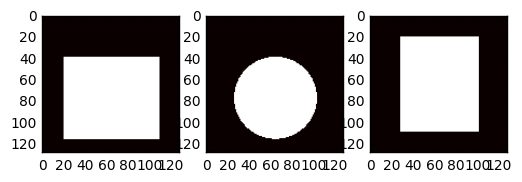

In [29]:
subplot(1,3,1); imshow(activity.data[:,:,64], cmap='hot')
subplot(1,3,2); imshow(activity.data[:,64,:], cmap='hot')
subplot(1,3,3); imshow(activity.data[64,:,:], cmap='hot')

#### 2) Simulate motion

In [30]:
N_frames = 4
Total_counts = 1e7 
random_translation_amplitude = 5.0   # mm
random_rotation_amplitude    = 2.0    # deg

In [31]:
Tx = np.random.normal(0,random_translation_amplitude,[N_frames,])
Ty = np.random.normal(0,random_translation_amplitude,[N_frames,])
Tz = np.random.normal(0,random_translation_amplitude,[N_frames,])
Rx = np.random.normal(0,random_rotation_amplitude,[N_frames,])
Ry = np.random.normal(0,random_rotation_amplitude,[N_frames,])
Rz = np.random.normal(0,random_rotation_amplitude,[N_frames,])

#### Note: occiput represents rigid transformations using the object RigidTransform. Example:

In [32]:
example_TR = RigidTransform( (1.0, 2.0, 3.0, pi, pi/2, 0.0) )
print example_TR.x, example_TR.y, example_TR.z
print example_TR.theta_x, example_TR.theta_y, example_TR.theta_z

1.0 2.0 3.0
3.14159265359 1.57079632679 0.0


#### 3) Simulate PET acquisition
In order to simulate the PET acquisition with motion, let us project the activity specifying the location of the activity phantom when projecting. Let's then add Poisson noise. For now, let us discard scatter, randoms and the attenuation map. It's straightforward to add these effects in the simulation and in the reconstructions that follow. 
Refer to the basic examples of static PET reconstruction to see how to include attenuation, scatter and randoms. 

In [33]:
prompts_series = []
transformations = []
for t in range(N_frames): 
    print t,"/",N_frames
    TR = RigidTransform((Tx[t],Ty[t],Tz[t],Rx[t],Ry[t],Rz[t]))
    prompts = pet.project_activity(activity, transformation=TR)
    prompts.data = prompts.data * (1.0*Total_counts/N_frames) / prompts.data.sum() 
    prompts.apply_noise_Poisson() 
    prompts_series.append(prompts) 
    transformations.append(TR)

0 / 4
1 / 4
2 / 4
3 / 4


## Reconstruct
Let us reconstruct the activity with various methods. For all methods we will use the same parameters of the OSEM algorithm: number of iterations, size of the subsets (number of projections in each subset), and the mode of selection of the subsets. 

In [34]:
iterations  = 5 
subset_size = 32 
subset_mode = "random" 

#### 1) Reconstruct frames independently with OSEM algorithm, unknown motion

In [35]:
activity_series_independent = []
for t in range(N_frames):
    print t,"/",N_frames
    pet.set_prompts(prompts_series[t]) 
    activity = pet.osem_reconstruction(iterations=iterations, subset_size=subset_size, subset_mode=subset_mode) 
    activity_series_independent.append(activity) 

0 / 4
0
1
2
3
4
1 / 4
0
1
2
3
4
2 / 4
0
1
2
3
4
3 / 4
0
1
2
3
4


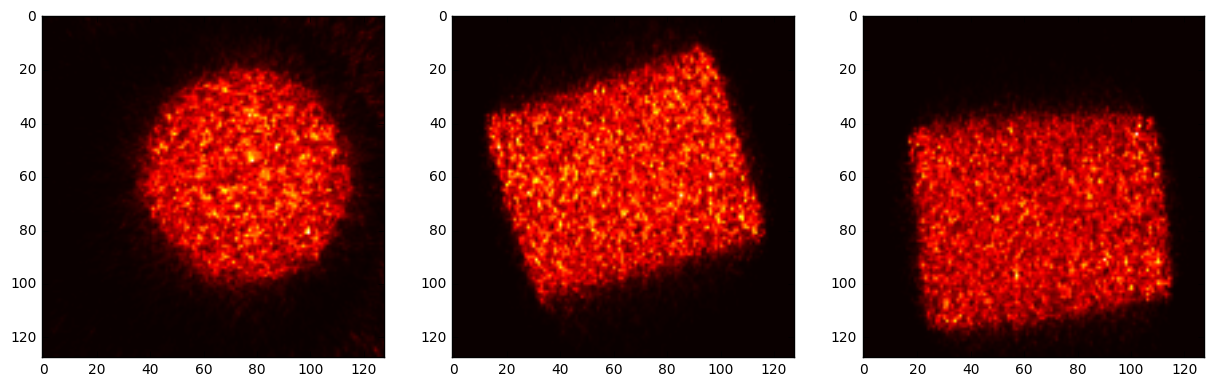

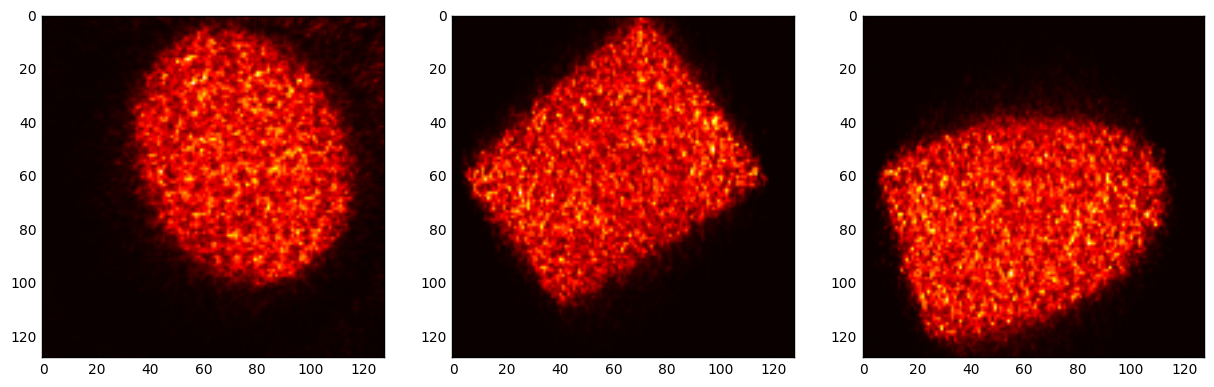

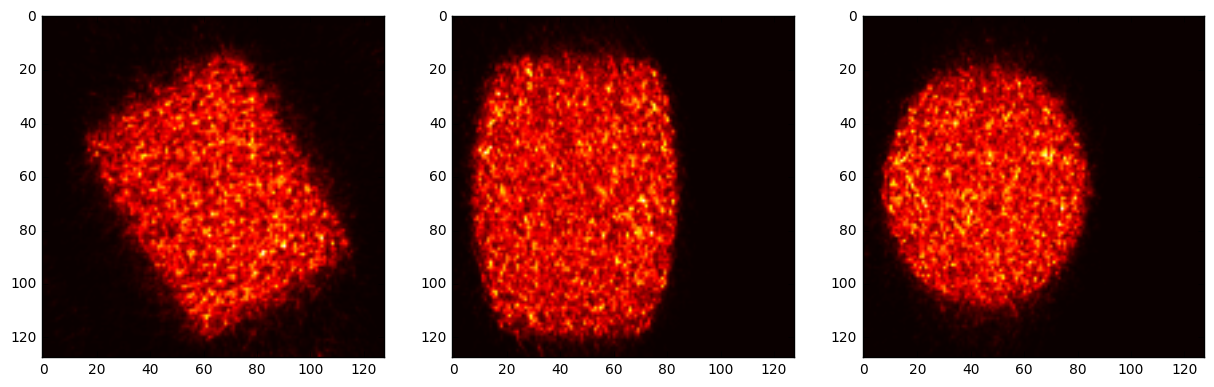

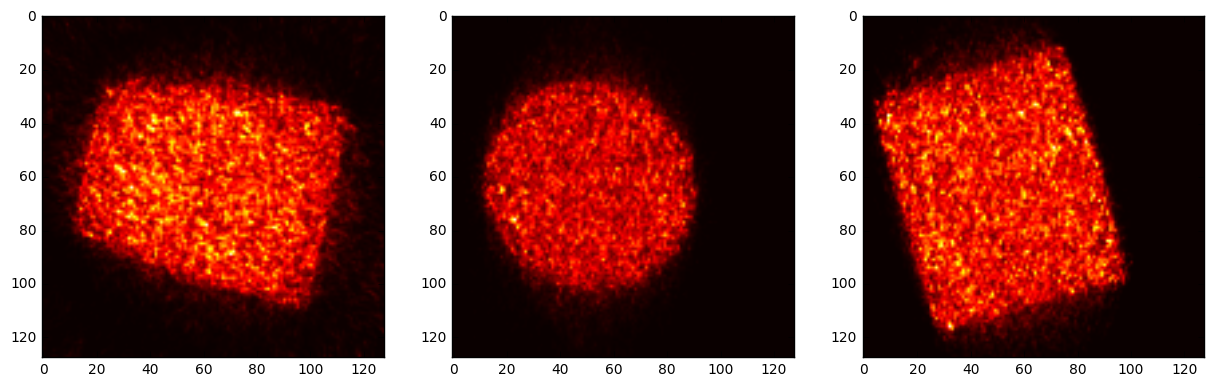

In [36]:
for t in range(N_frames):
    figure(figsize=[15,5])
    a = activity_series_independent[t]
    subplot(1,3,1); imshow(a.data[:,:,64], cmap='hot'); 
    subplot(1,3,2); imshow(a.data[:,64,:], cmap='hot'); 
    subplot(1,3,3); imshow(a.data[64,:,:], cmap='hot'); 

#### 2) Reconstruct frames independently with OSEM algorithm, known motion - version A: use PET_Static_Scan
All we need to do is specify the transformation as an optional parameter to the OSEM algorithm when reconstucting a frame. Under the hood, the transformation is passed on to the projector and to the back-projector. 

In [37]:
activity_series_independent_motion = []
for t in range(N_frames):
    print t,"/",N_frames
    pet.set_prompts(prompts_series[t]) 
    activity = pet.osem_reconstruction(iterations=iterations, subset_size=subset_size, subset_mode=subset_mode, transformation=transformations[t]) 
    activity_series_independent_motion.append(activity) 

0 / 4
0
1
2
3
4
1 / 4
0
1
2
3
4
2 / 4
0
1
2
3
4
3 / 4
0
1
2
3
4


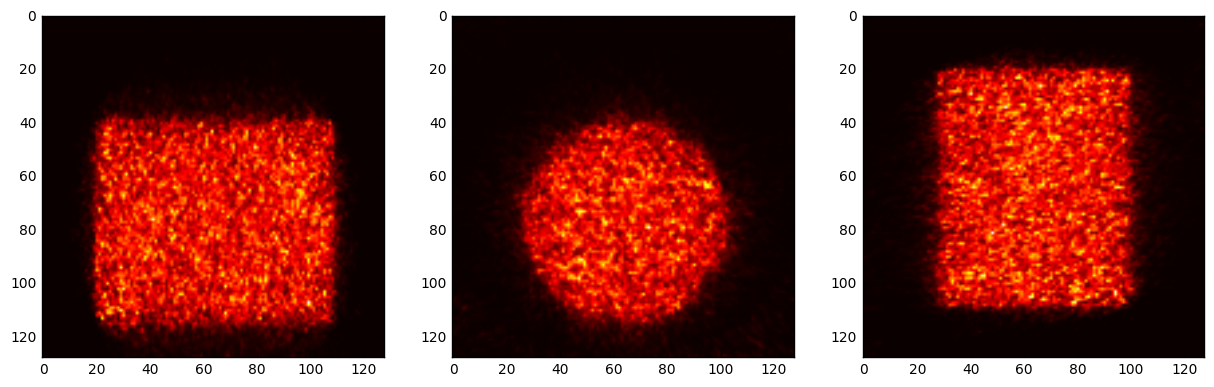

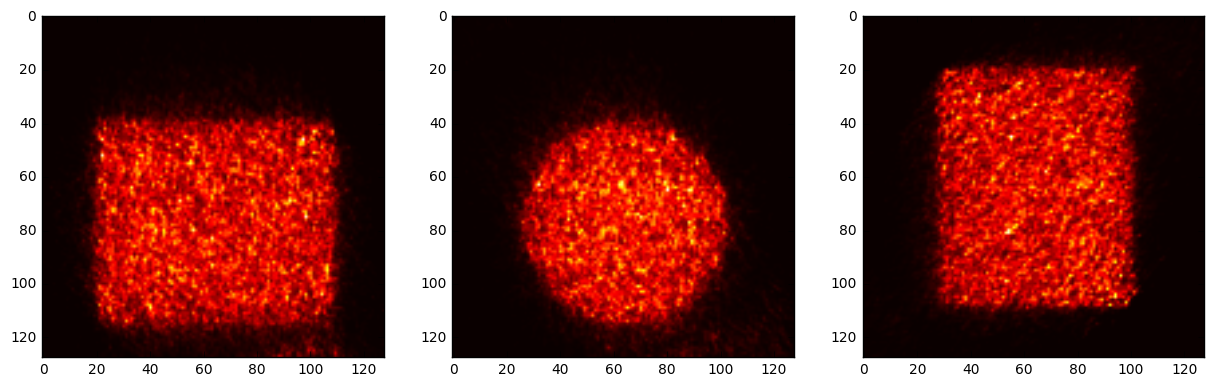

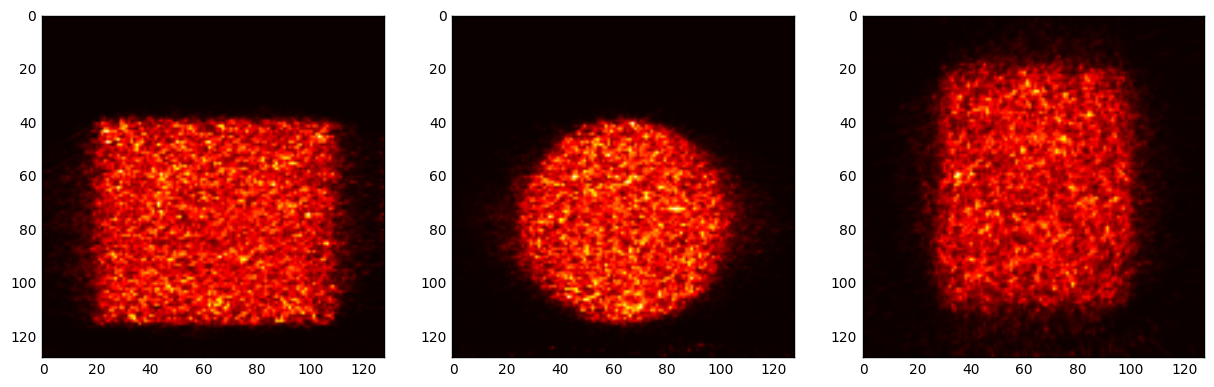

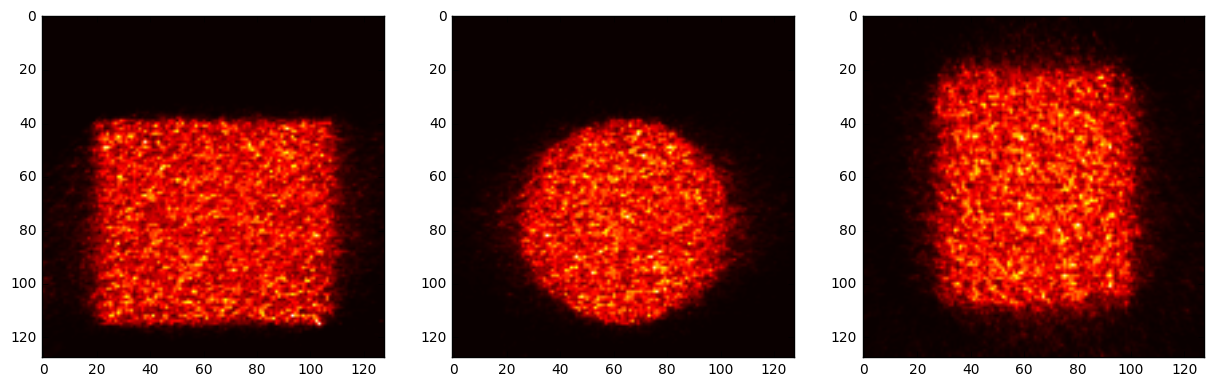

In [38]:
for t in range(N_frames):
    figure(figsize=[15,5])
    a = activity_series_independent_motion[t]
    subplot(1,3,1); imshow(a.data[:,:,64], cmap='hot'); 
    subplot(1,3,2); imshow(a.data[:,64,:], cmap='hot'); 
    subplot(1,3,3); imshow(a.data[64,:,:], cmap='hot');

#### 3) Reconstruct frames independently  with OSEM algorithm, known motion - version B: use PET_Dynamic_Scan
This produces the same result as 2), but using the PET_Dynamic_Scan object. 
PET_Dynamic_Scan represents a series of PET acquisitions. It has a global method osem_reconstruction() that reconstructs all frames (independently). 

In [39]:
pet_dyn = PET_Dynamic_Scan()

In [40]:
pet_dyn.set_scanner(Generic)

In [41]:
pet_dyn.set_prompts(prompts_series)

PET_Dynamic_Scan.set_prompts(): Number of sinograms does not match current setup; re-initialization.


In [42]:
pet_dyn.osem_reconstruction(iterations=iterations, subset_size=subset_size, subset_mode=subset_mode, transformations=transformations) 

Reconstructing frame 0/4
0
1
2
3
4
Reconstructing frame 1/4
0
1
2
3
4
Reconstructing frame 2/4
0
1
2
3
4
Reconstructing frame 3/4
0
1
2
3
4


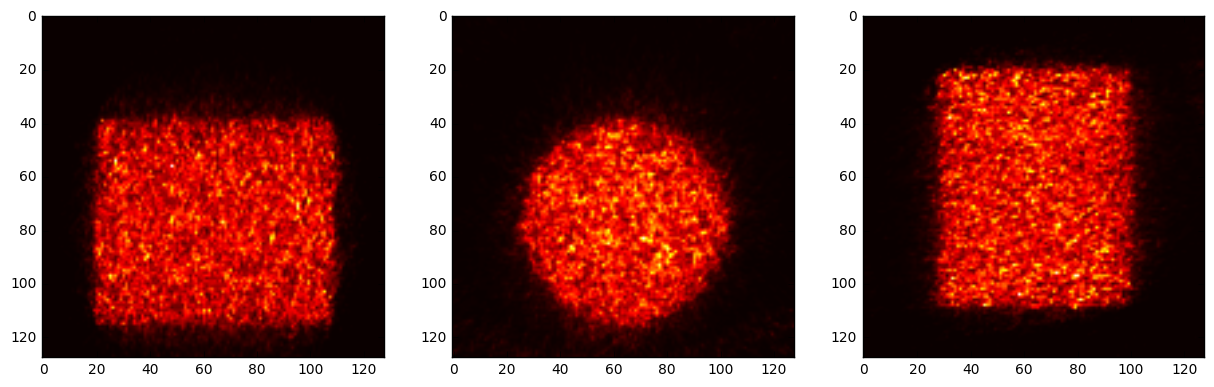

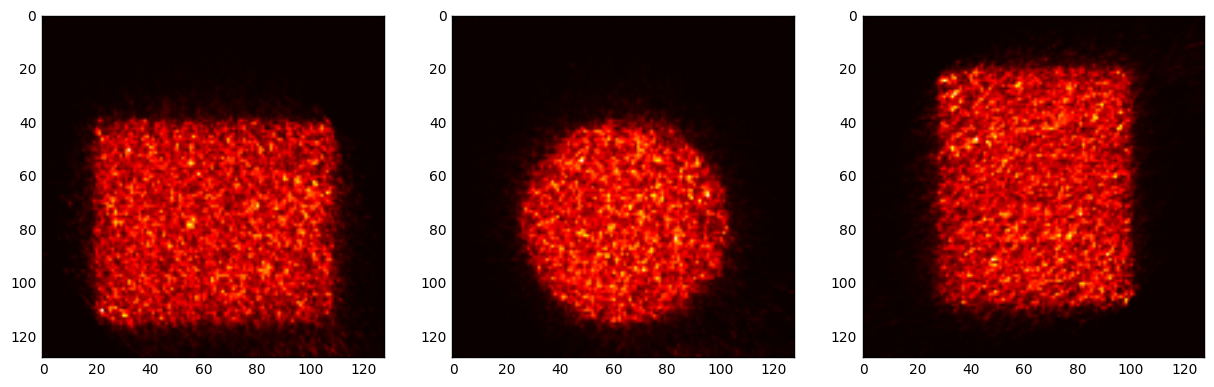

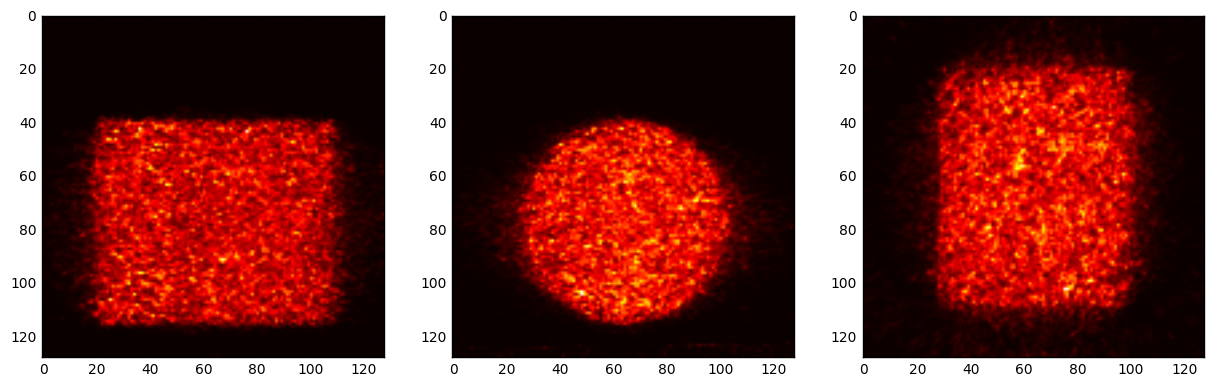

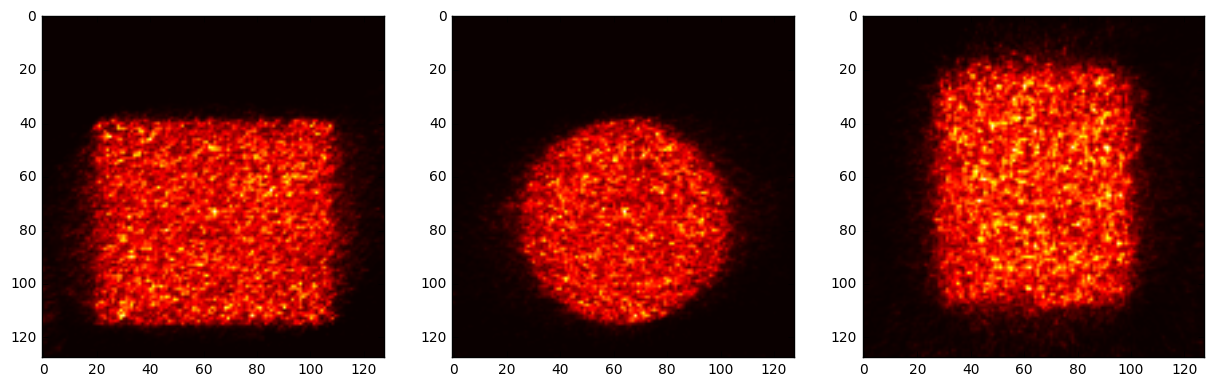

In [43]:
for t in range(N_frames): 
    figure(figsize=[15,5])
    a = pet_dyn[t].activity
    subplot(1,3,1); imshow(a.data[:,:,64], cmap='hot'); 
    subplot(1,3,2); imshow(a.data[:,64,:], cmap='hot'); 
    subplot(1,3,3); imshow(a.data[64,:,:], cmap='hot');

#### 4) 4-Dimensional reconstruction using OSEM algorithm, known motion
PET_Dynamic_Scan also has a method osem_reconstruction_4D, which reconstructs a single frame using the sinogram time series and the motion information. 

In [44]:
activity = pet_dyn.osem_reconstruction_4D(iterations=iterations, subset_size=subset_size, subset_mode=subset_mode, transformations=transformations)

0
1
2
3
4


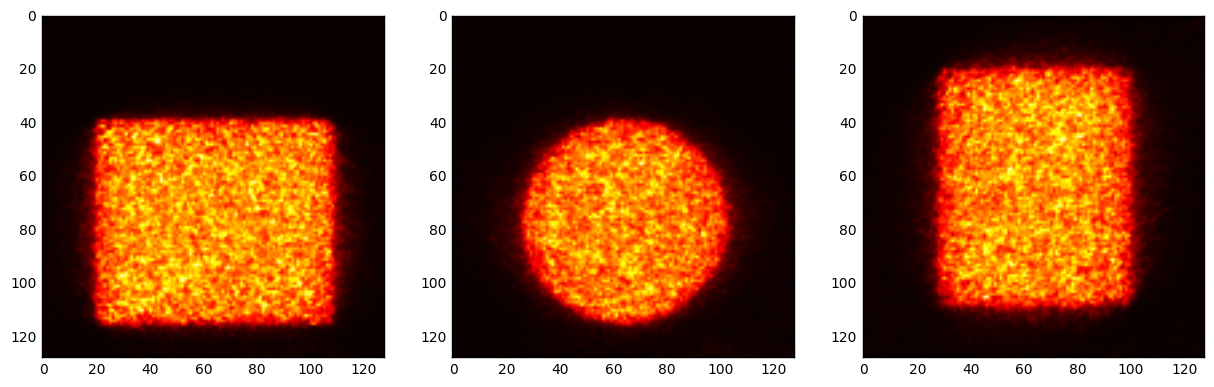

In [45]:
figure(figsize=[15,5])
subplot(1,3,1); imshow(activity.data[:,:,64], cmap='hot'); 
subplot(1,3,2); imshow(activity.data[:,64,:], cmap='hot'); 
subplot(1,3,3); imshow(activity.data[64,:,:], cmap='hot');